# <center> Trends in Financial Data Science HW2 </center>

&copy; Kaiwen Zhou 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from pykalman import KalmanFilter
from numpy.linalg import inv
import scipy.stats as spst

# Topic: Kalman filter’s Application on Financial Problems — Pairs Trading

## Simulate the OU process

To conform the notation used in the Kalman filter, we use $t\in
            \mathbb{N}$ to denote the states and write the result in (a) as:
          $$
            s_t = \theta - e^{-\kappa\Delta t}\theta + e^{-\kappa\Delta t} s_{t-1} + \varepsilon_t \quad  \text{ where } \quad  \varepsilon_t \sim \mathcal{N}\left(0, \frac{\sigma^2}{2\kappa} \left(1-e^{-2\kappa \Delta t}\right)\right)
          $$

In [3]:
spst.norm(0, 1)

In [4]:
np.random.normal(0,1)

1.6762822927231074

In [27]:
np.random.seed(990)
# Parameters
κ = 3
θ = 1.5
σ = 0.2

N = 20000  # time steps
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)
std = np.sqrt(σ**2 / (2 * κ) * (1 - np.exp(-2 * κ * dt)))

s_process = [1] # s_0 = 1, we start with 1
for i in range(1, N):
    s_next = θ - np.exp(-κ * dt) * θ + np.exp(-κ * dt) * s_process[i-1] + std * np.random.normal(0, 1)
    s_process += [ s_next ]
    
s_process = np.array(s_process)   
theoretical_mean_curve = np.array([np.exp(-κ * t) * s_process[0] + θ * (1 - np.exp(-κ * t)) for t in T_vec])

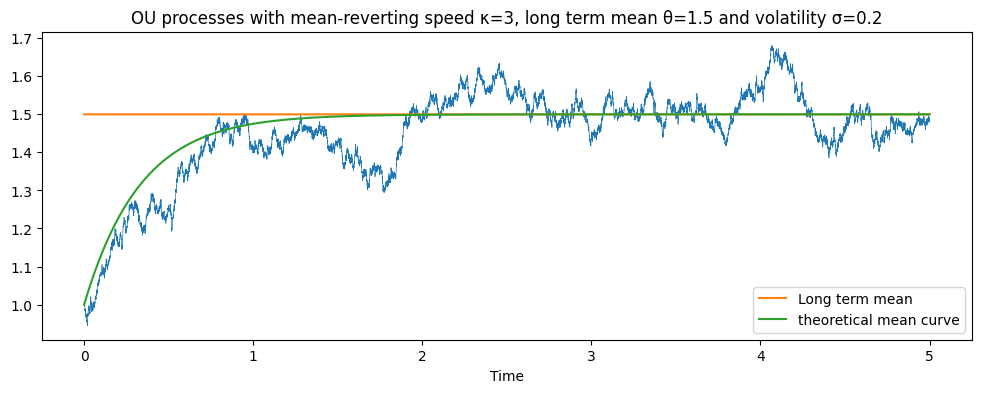

In [28]:
fig = plt.figure(figsize=(12, 4))
plt.plot(T_vec, s_process, linewidth=0.5)
plt.plot(T_vec, θ * np.ones_like(T_vec), label="Long term mean")
plt.plot(T_vec, theoretical_mean_curve, label="theoretical mean curve")
plt.legend(loc="lower right")
plt.title(f"OU processes with mean-reverting speed κ={κ}, long term mean θ={θ} and volatility σ={σ}")
plt.xlabel("Time")
plt.show()

## Use Kalman filter to update parameters κ, θ and σ

In [30]:
θ - np.exp(-κ * dt) * θ, np.exp(-κ * dt)

(0.0011246344410866804, 0.9992502437059422)

In [31]:
np.log(0.9992502437059422) / (-dt)

2.999999999999904

In [32]:
# initial Guess
x_00 = np.array([2, 2]).reshape(-1, 1)
P_00 = np.eye(2) * 0.1

# latent state variables sequence
x_sequence = [x_00]
P_sequence = [P_00]

k0 = np.log(x_sequence[0][1]) / (-dt)
θ0 = x_sequence[0][0] / (1-x_sequence[0][1])
# 
Q_t = np.eye(2) * 0
R_t = σ**2 / (2 * k0) * (1 - np.exp(-2 * k0 * dt))

for t in range(1, N):
    F_t = np.eye(2)
    H_t = np.array([1, s_process[t-1]]).reshape(1,-1)
    I = np.eye(2)
    
    # predict step
    x_t_tminus1 = F_t@x_sequence[t-1]
    P_t_tminus1 = F_t@P_sequence[t-1]@F_t.T + Q_t
    # print(x_t_tminus1.shape, P_t_tminus1.shape, H_t.shape)
    
    kt = np.log(x_sequence[t-1][1]) / (-dt)
    θt = x_sequence[t-1][0] / (1-x_sequence[t-1][1])
    R_t = σ**2 / (2 * kt) * (1 - np.exp(-2 * kt * dt))
    # update step
    S_t = H_t@P_t_tminus1@H_t.T + R_t 
    K_t = P_t_tminus1@H_t.T@inv(S_t)
    
    x_tt = x_t_tminus1 + K_t@(s_process[t] - H_t@x_t_tminus1)
    P_tt = (I - H_t@K_t)@P_t_tminus1
    
    x_sequence += [x_tt]
    P_sequence += [P_tt]
    

In [33]:
x_sequence[2], x_sequence[-1]

(array([[0.49875172],
        [0.49875151]]),
 array([[0.5182369 ],
        [0.65317369]]))

In [34]:
dt

0.00025001250062503126

In [35]:
-np.log(x_sequence[-1][1])/dt, x_sequence[-1][0] / (1-x_sequence[-1][1])

(array([1703.56362747]), array([1.49422602]))

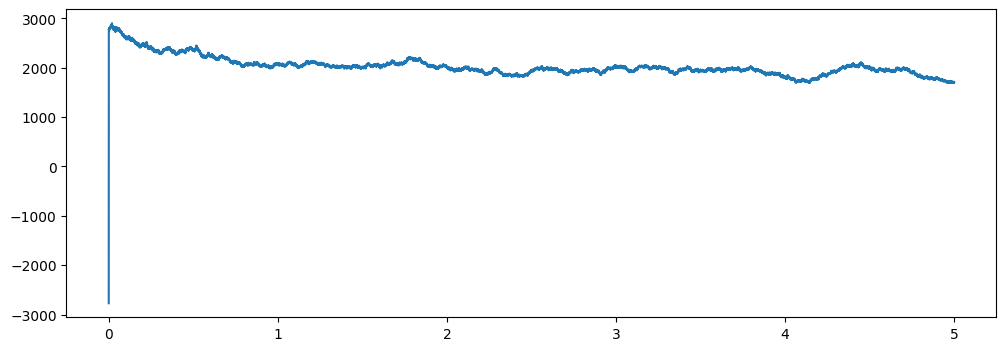

In [36]:
fig = plt.figure(figsize=(12, 4))
kappa_get = [-np.log(xx[1])/dt for xx in x_sequence]
plt.plot(T_vec, kappa_get)

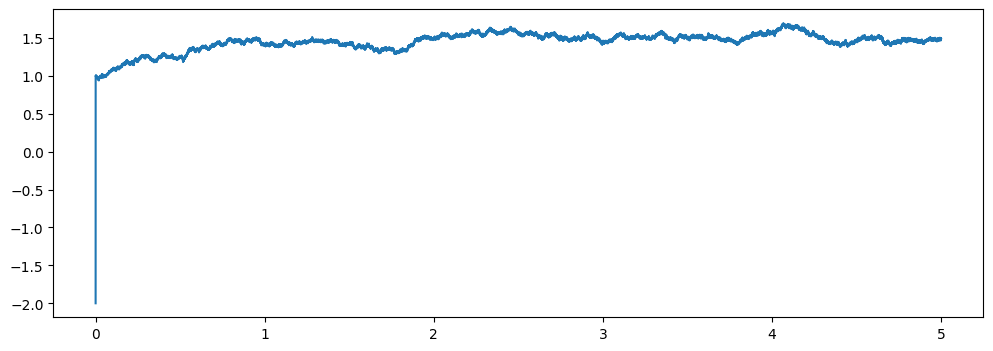

In [37]:
fig = plt.figure(figsize=(12, 4))
theta_get = [xx[0]/(1-xx[1]) for xx in x_sequence]
plt.plot(T_vec, theta_get)